# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## The challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## The data

| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |	
| Age | Age in years |	
| sibsp | # of siblings / spouses aboard the Titanic |	
| parch | # of parents / children aboard the Titanic |	
| ticket | Ticket number |	
| fare | Passenger fare	|
| cabin	| Cabin number |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

**pclass**: A proxy for socio-economic status (SES)

* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.


# Importing libraries

In [824]:
import pandas               as pd
import numpy                as np 
import matplotlib.pyplot    as plt
import seaborn              as sns

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate, GridSearchCV
from sklearn import feature_selection, model_selection, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# EDA

In [825]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat([train, test], axis=0, join='outer', ignore_index=False)

In [826]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [827]:
print('Summary: ')
print(round(all_data[['Age', 'SibSp', 'Parch', 'Fare']].describe().transpose(), 2))

print('Numerical variables: ')
for x in all_data.select_dtypes(exclude=['object']):
    print('\t'+x)

print('Categorical variables: ')
for x in all_data.select_dtypes(include=['object']):
    print('\t'+x)

print('Missing data count: ')
missing_data = all_data.isna().sum()
print(missing_data[missing_data>0])

Summary: 
        count   mean    std   min   25%    50%    75%     max
Age    1046.0  29.88  14.41  0.17  21.0  28.00  39.00   80.00
SibSp  1309.0   0.50   1.04  0.00   0.0   0.00   1.00    8.00
Parch  1309.0   0.39   0.87  0.00   0.0   0.00   0.00    9.00
Fare   1308.0  33.30  51.76  0.00   7.9  14.45  31.28  512.33
Numerical variables: 
	PassengerId
	Survived
	Pclass
	Age
	SibSp
	Parch
	Fare
Categorical variables: 
	Name
	Sex
	Ticket
	Cabin
	Embarked
Missing data count: 
Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [828]:
train.groupby(by='Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


## Numeric variables

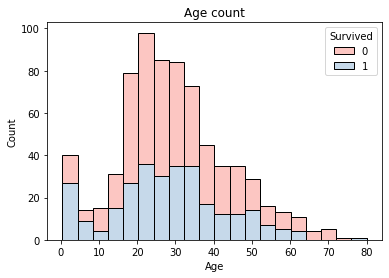

In [829]:
sns.histplot(data=train, x='Age', hue='Survived', multiple="stack")
plt.title('Age count')
plt.xlabel('Age');

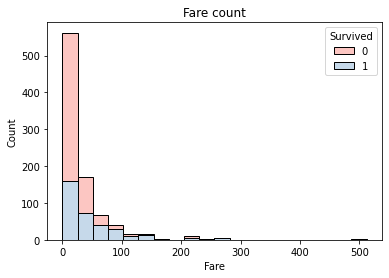

In [830]:
sns.histplot(data=train, x='Fare', hue='Survived', multiple="stack", bins = 20)
plt.title('Fare count')
plt.xlabel('Fare')
plt.show()

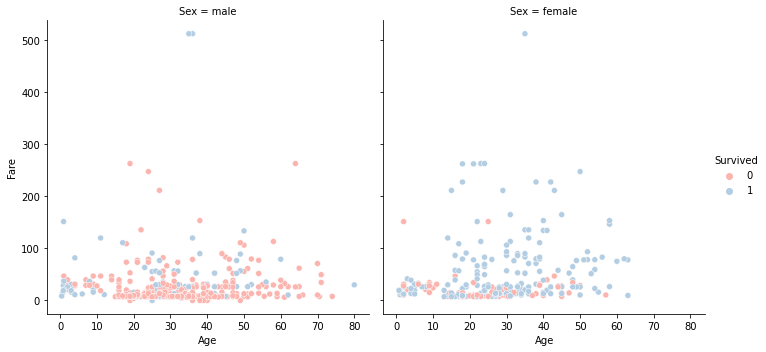

In [831]:
sns.relplot(x='Age', y='Fare', data=train, kind='scatter', hue='Survived', col='Sex');

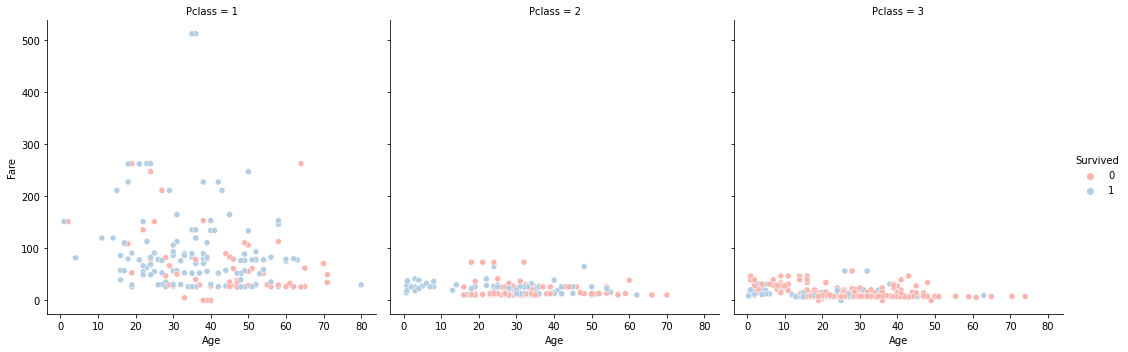

In [832]:
sns.relplot(x='Age', y='Fare', data=train, kind='scatter', hue='Survived', col='Pclass');

### Detecting Outliers

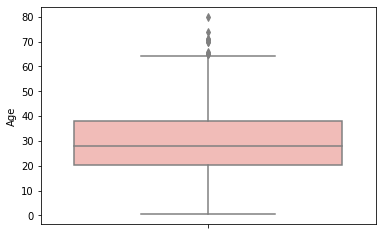

In [833]:
sns.boxplot(y='Age', data=train);

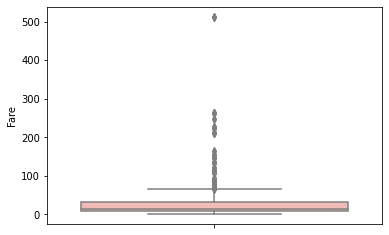

In [834]:
sns.boxplot(y='Fare', data=train);

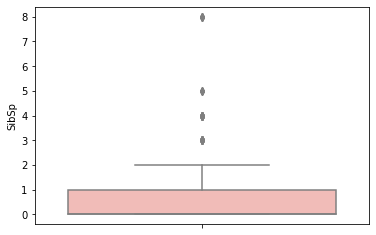

In [835]:
sns.boxplot(y='SibSp', data=train);

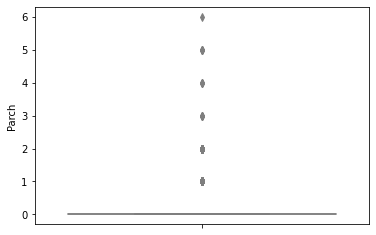

In [836]:
sns.boxplot(y='Parch', data=train);

## Categorical variables

In [837]:
categorical = ['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked']
all_data[categorical].astype('category')
all_data[categorical].nunique()

Survived      2
Pclass        3
Sex           2
Cabin       186
Embarked      3
dtype: int64

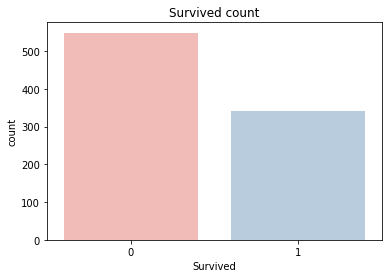

In [838]:
sns.set_palette('Pastel1')
sns.countplot(data=train, x='Survived')
plt.title('Survived count');

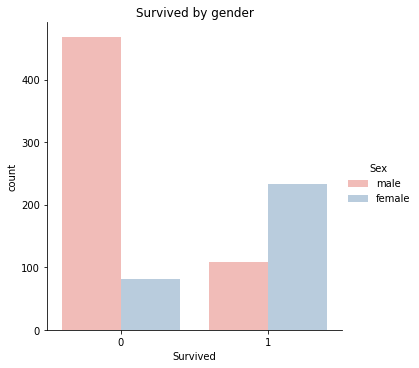

In [839]:
sns.catplot(x="Survived", data=train, kind="count", hue="Sex")
plt.title('Survived by gender');

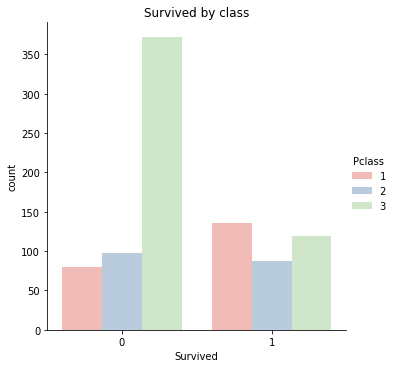

In [840]:
sns.catplot(x="Survived", data=train, kind="count", hue="Pclass")
plt.title('Survived by class');

In [841]:
pd.crosstab([train['Embarked'], train['Pclass']], [train['Sex'], train['Survived']], margins=True).style.background_gradient(cmap='YlOrRd')

In [842]:
all_data['Cabin'].fillna("X", inplace = True)
all_data['Section'] = all_data['Cabin'].str.slice(0, 1)
train['Section'] = all_data['Section'][:891]
test['Section'] = all_data['Section'][891:]

In [843]:
pd.crosstab([train['Section']], [train['Survived']], margins=False, normalize='index').style.background_gradient(cmap='YlOrRd')

Survived,0,1
Section,,
A,0.533333,0.466667
B,0.255319,0.744681
C,0.406780,0.593220
D,0.242424,0.757576
E,0.250000,0.750000
F,0.384615,0.615385
G,0.500000,0.500000
T,1.000000,0.000000
X,0.700146,0.299854


# Data cleaning

## Missing data

In [844]:
all_data['Title'] = all_data['Name']
for name in all_data['Name']:
    all_data['Title'] = all_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
all_data.groupby(['Title']).size()

Title
Capt          1
Col           4
Countess      1
Don           1
Dona          1
Dr            8
Jonkheer      1
Lady          1
Major         2
Master       61
Miss        260
Mlle          2
Mme           1
Mr          757
Mrs         197
Ms            2
Rev           8
Sir           1
dtype: int64

In [845]:
title_remap = {'Capt':'Mr', 'Col':'Mr', 'Countess':'Mrs', 'Don':'Mr', 'Dona':'Mrs', 'Jonkheer':'Master', 'Lady':'Mrs', 'Major':'Mr', 'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Mrs', 'Sir':'Mr'}
all_data.replace({'Title': title_remap}, inplace=True)
main_titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in main_titles:
    imputed_age = all_data.groupby(['Title'])['Age'].median()[main_titles.index(title)]
    all_data.loc[(all_data['Age'].isna()) & (all_data['Title'] == title), 'Age'] = imputed_age
train['Age'] = all_data['Age'][:891]
test['Age'] = all_data['Age'][:891]

In [846]:
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace=True)
all_data['Fare'].fillna(all_data['Fare'].median(), inplace=True)
train['Embarked'] = all_data['Embarked'][:891]
test['Fare'] = all_data['Fare'][:891]

## Feature engineering

In [847]:
train[['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [848]:
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [849]:
all_data['FamilySize'] = all_data['Parch']+all_data['SibSp']+1
train['FamilySize'] = all_data['FamilySize'][:891]
test['FamilySize'] = all_data['FamilySize'][891:]
train[['FamilySize', 'Survived']].groupby(['FamilySize']).mean()

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


In [850]:
all_data.assign(Alone=0)
all_data.loc[all_data['FamilySize'] == 1, 'Alone'] = 1
all_data.loc[all_data['FamilySize'] > 1, 'Alone'] = 0
train['Alone'] = all_data['Alone'][:891].astype(int)
test['Alone'] = all_data['Alone'][891:].astype(int)
train[['Alone', 'Survived']].groupby(['Alone']).mean()

,Survived
Alone,
0,0.505650
1,0.303538


In [851]:
train[['Embarked', 'Survived']].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


In [852]:
train[['Section', 'Survived']].groupby(['Section']).mean()

,Survived
Section,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
X,0.299854


In [853]:
all_data['CategoryFare'] = pd.qcut(all_data['Fare'], 4)
train['CategoryFare'] = all_data['CategoryFare'][:891]
test['CategoryFare'] = all_data['CategoryFare'][:891]
train[['CategoryFare', 'Survived']].groupby(['CategoryFare']).mean()

,Survived
CategoryFare,
"(-0.001, 7.896]",0.197309
"(7.896, 14.454]",0.303571
"(14.454, 31.275]",0.441048
"(31.275, 512.329]",0.600000


In [854]:
all_data['CategoryAge'] = pd.qcut(all_data['Age'], 5)
train['CategoryAge'] = all_data['CategoryAge'][:891]
test['CategoryAge'] = all_data['CategoryAge'][:891]
train[['CategoryAge', 'Survived']].groupby(['CategoryAge']).mean()

,Survived
CategoryAge,
"(0.169, 21.0]",0.427885
"(21.0, 26.0]",0.430464
"(26.0, 29.5]",0.217391
"(29.5, 39.0]",0.472826
"(39.0, 80.0]",0.371951


In [855]:
train['Title'] = all_data['Title'][:891]
test['Title'] = all_data['Title'][:891]
train[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Dr,0.428571
Master,0.560976
Miss,0.701087
Mr,0.160305
Mrs,0.798450
Rev,0.000000


## Data transformation

In [856]:
'''label = LabelEncoder()
all_data['FareCode'] = label.fit_transform(all_data['CategoryFare'])
train['FareCode'] = all_data['FareCode'][:891]
test['FareCode'] = all_data['FareCode'][:891]
train.drop(['Fare', 'CategoryFare'], axis=1, inplace=True)
test.drop(['Fare', 'CategoryFare'], axis=1, inplace=True)'''
all_data.loc[ all_data['Fare'] <= 7.896, 'Fare']                                    = 0
all_data.loc[(all_data['Fare'] > 7.896) & (all_data['Fare'] <= 14.454), 'Fare']     = 1
all_data.loc[(all_data['Fare'] > 14.454) & (all_data['Fare'] <= 31.275), 'Fare']     = 2
all_data.loc[ all_data['Fare'] > 31.275, 'Fare']                                     = 3
all_data['Fare'] = all_data['Fare'].astype(int)
train['Fare'] = all_data['Fare'][:891]
test['Fare'] = all_data['Fare'][:891]

In [857]:
'''label = LabelEncoder()
all_data['AgeCode'] = label.fit_transform(all_data['CategoryAge'])
train['AgeCode'] = all_data['AgeCode'][:891]
test['AgeCode'] = all_data['AgeCode'][:891]
train.drop(['Age', 'CategoryAge'], axis=1, inplace=True)
test.drop(['Age', 'CategoryAge'], axis=1, inplace=True)'''
all_data.loc[ all_data['Age'] <= 21.0, 'Age']                               = 0
all_data.loc[(all_data['Age'] > 21.0) & (all_data['Age'] <= 26.0), 'Age']   = 1
all_data.loc[(all_data['Age'] > 26.0) & (all_data['Age'] <= 29.5), 'Age']   = 2
all_data.loc[(all_data['Age'] > 29.5) & (all_data['Age'] <= 39.0), 'Age']   = 3
all_data.loc[ all_data['Age'] > 39.0, 'Age']                               = 4
all_data['Age'] = all_data['Age'].astype(int)
train['Age'] = all_data['Age'][:891]
test['Age'] = all_data['Age'][:891]


In [858]:
'''label = LabelEncoder()
all_data['SectionCode'] = label.fit_transform(all_data['Section'])
train['SectionCode'] = all_data['SectionCode'][:891]
test['SectionCode'] = all_data['SectionCode'][:891]
train.drop(['Cabin', 'Section'], axis=1, inplace=True)
test.drop(['Cabin', 'Section'], axis=1, inplace=True)'''
all_data['Section'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'], [1, 0, 1, 0, 0, 1, 1, 2, 2],inplace=True)
train['Section'] = all_data['Section'][:891]
test['Section'] = all_data['Section'][:891]

In [859]:
'''label = LabelEncoder()
all_data['TitleCode'] = label.fit_transform(all_data['Title'])
train['TitleCode'] = all_data['TitleCode'][:891]
test['TitleCode'] = all_data['TitleCode'][:891]
train.drop(['Title', 'Name'], axis=1, inplace=True)
test.drop(['Title', 'Name'], axis=1, inplace=True)'''
all_data['Title'].replace(['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev'], [4, 3, 1, 0, 2, 4],inplace=True)
train['Title'] = all_data['Title'][:891]
test['Title'] = all_data['Title'][:891]

In [860]:
'''label = LabelEncoder()
all_data['EmbarkedCode'] = label.fit_transform(all_data['Embarked'])
train['EmbarkedCode'] = all_data['EmbarkedCode'][:891]
test['EmbarkedCode'] = all_data['EmbarkedCode'][:891]
train.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)'''
all_data['Embarked'].replace(['C', 'Q', 'S'], [1, 2, 0],inplace=True)
train['Embarked'] = all_data['Embarked'][:891]
test['Embarked'] = all_data['Embarked'][:891]

In [861]:
all_data['Sex'].replace(['female', 'male'], [0, 1],inplace=True)
train['Sex'] = all_data['Sex'][:891]
test['Sex'] = all_data['Sex'][:891]

In [862]:
train.drop(['PassengerId', 'SibSp', 'Parch', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'SibSp', 'Parch', 'Ticket'], axis=1, inplace=True)

In [863]:
train.drop(['Name', 'Cabin', 'CategoryFare', 'CategoryAge'], axis=1, inplace=True)
test.drop(['Name', 'Cabin', 'CategoryFare', 'CategoryAge'], axis=1, inplace=True)

In [864]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Section,FamilySize,Alone,Title
0,0,3,1,1,0,0,2,2,0,0
1,1,1,0,3,3,1,1,2,0,2
2,1,3,0,1,1,0,2,1,1,1
3,1,1,0,3,3,0,1,2,0,2
4,0,3,1,3,1,0,2,1,1,0


In [865]:
test.head()

,Pclass,Sex,Age,Fare,Embarked,Section,FamilySize,Alone,Title
0,3,1,1,0,0,2,1,1,0
1,3,0,3,3,1,1,2,0,2
2,2,0,1,1,0,2,1,1,1
3,3,0,3,3,0,1,1,1,2
4,3,1,3,1,0,2,3,0,0


# Models

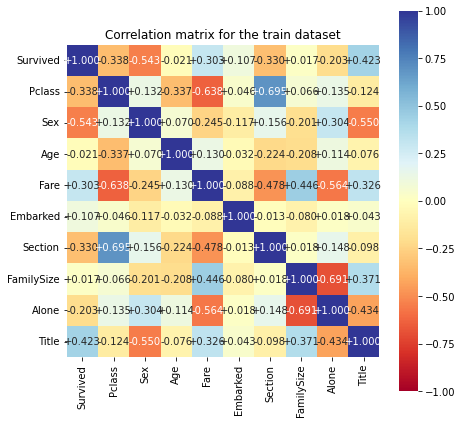

In [866]:
plt.figure(figsize=(7,7))
sns.heatmap(train.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Correlation matrix for the train dataset")
plt.show()

In [867]:
def concat_test_pred(y_test, y_pred):
    
    df_test = y_test.to_frame(name='Survived').reset_index().drop(columns='index')
    df_pred = pd.Series(y_pred).to_frame(name='Prediction')
    results = pd.concat([df_test, df_pred], axis=1)
    
    return results

In [ ]:
def performance_metrics(results):
    
    positives = results[['Survived', 'Prediction']][results['Survived'] == 1]
    negatives = results[['Survived', 'Prediction']][results['Survived'] == 0]
    
    true_negatives = negatives[negatives['Survived'] == negatives['Prediction']].shape[0]
    false_positives = negatives[negatives['Survived'] != negatives['Prediction']].shape[0]
    true_positives = positives[positives['Survived'] == positives['Prediction']].shape[0]
    false_negatives = positives[positives['Survived'] != positives['Prediction']].shape[0]
    
    confusion_matrix = {'actual positives' : [true_positives, false_negatives], 
                        'actual negatives' : [false_positives, true_negatives]}
    
    confusion_matrix_df = pd.DataFrame.from_dict(confusion_matrix, orient='index', 
                                                 columns=['predicted positives', 'predicted negatives'])
    
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives +  true_negatives + false_negatives)
    precission = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precission * recall) / (precission + recall)
    
    metrics = {'Accuracy' : accuracy, 'Precission' : precission, 'Recall' : recall, 'F1 Score' : f1_score}
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Metrics'])
    
    return confusion_matrix_df, metrics_df  

In [868]:
X = train.copy()
#X.drop(['FamilySize', 'Age', 'Embarked', 'Alone', 'Title'], axis=1, inplace=True)
X.drop(['Section'], axis=1, inplace=True)
y = X['Survived']
X.drop('Survived', axis=1, inplace=True)
X_test = test.copy()
#X_test.drop(['FamilySize', 'Age', 'Embarked', 'Alone', 'Title'], axis=1, inplace=True)
X_test.drop(['Section'], axis=1, inplace=True)

In [869]:
X

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Alone,Title
0,3,1,1,0,0,2,0,0
1,1,0,3,3,1,2,0,2
2,3,0,1,1,0,1,1,1
3,1,0,3,3,0,2,0,2
4,3,1,3,1,0,1,1,0
...,...,...,...,...,...,...,...,...
886,2,1,2,1,0,1,1,4
887,1,0,0,2,0,1,1,1
888,3,0,1,2,0,4,0,1
889,1,1,1,2,1,1,1,0


In [870]:
'''std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)'''

'std_scaler = StandardScaler()\nX = std_scaler.fit_transform(X)\nX_test = std_scaler.transform(X_test)'

In [871]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X, y)
y_pred_tree = decision_tree.predict(X_test)
accuracy = round(decision_tree.score(X, y) * 100, 2)
print("Model Accuracy: ", accuracy)

Model Accuracy:  89.45


In [872]:
random_model = RandomForestClassifier().fit(X, y)
y_pred_rand = random_model.predict(X_test)
accuracy = round(random_model.score(X, y) * 100, 2)
print("Model Accuracy: ", accuracy)

Model Accuracy:  89.45


In [873]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')
knn.fit(X, y)
y_pred_knn = knn.predict(X_test)
accuracy = round(knn.score(X, y) * 100, 2)
print("Model Accuracy: ", accuracy)

Model Accuracy:  85.07


In [874]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error').fit(X, y)
y_pred_xgb = xgb_model.predict(X_test)
accuracy = round(xgb_model.score(X, y) * 100, 2)
print("Model Accuracy: ", accuracy)

Model Accuracy:  89.11


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [875]:
'''# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}'''

"# Number of trees in random forest\nn_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]\n# Minimum number of samples required to split a node\n# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]\nmin_samples_split = [1, 2, 5, 10, 15, 20, 30]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 3, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Criterion\ncriterion=['gini', 'entropy']\nrandom_grid = {'n_estimators': n_estimators,\n#                'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap,\n               'criterion': criterio

In [876]:
'''{'n_estimators': np.array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']}'''

"{'n_estimators': np.array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,\n        2378, 2585, 2792, 3000]),\n 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],\n 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],\n 'min_samples_leaf': [1, 2, 3, 4],\n 'bootstrap': [True, False],\n 'criterion': ['gini', 'entropy']}"

In [877]:
'''rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)

rf_random.fit(X_train, y_train)
y_pred_rf = rf_random.predict(X_test)'''

'rf_base = RandomForestClassifier()\nrf_random = RandomizedSearchCV(estimator = rf_base,\n                               param_distributions = random_grid,\n                               n_iter = 30, cv = 5,\n                               verbose=2,\n                               random_state=42, n_jobs = 4)\n\nrf_random.fit(X_train, y_train)\ny_pred_rf = rf_random.predict(X_test)'

In [878]:
test_df = pd.read_csv('test.csv')

In [879]:
results = pd.DataFrame(test_df['PassengerId'])
results['Survived'] = y_pred_tree
results.to_csv('ResultsTree_Final2.csv', index=False)

In [880]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0
